<a href="https://colab.research.google.com/github/maithi05/Brainwave_Matrix_Intern/blob/main/Natural_Gas_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Load the Data

In [ ]:
import pandas as pd

# Load data from CSV
df = pd.read_csv("Nat_Gas.csv")  # Ensure this file is in your working directory
df['Dates'] = pd.to_datetime(df['Dates'])  # Convert to datetime
df.set_index('Dates', inplace=True)  # Set as time index
df = df.asfreq('M')  # Set frequency to monthly
df.index.name = 'Date'

df.head()


/tmp/ipython-input-5-3448256887.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])  # Convert to datetime
/tmp/ipython-input-5-3448256887.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.asfreq('M')  # Set frequency to monthly


,Prices
Date,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


Visualize the Historical Data

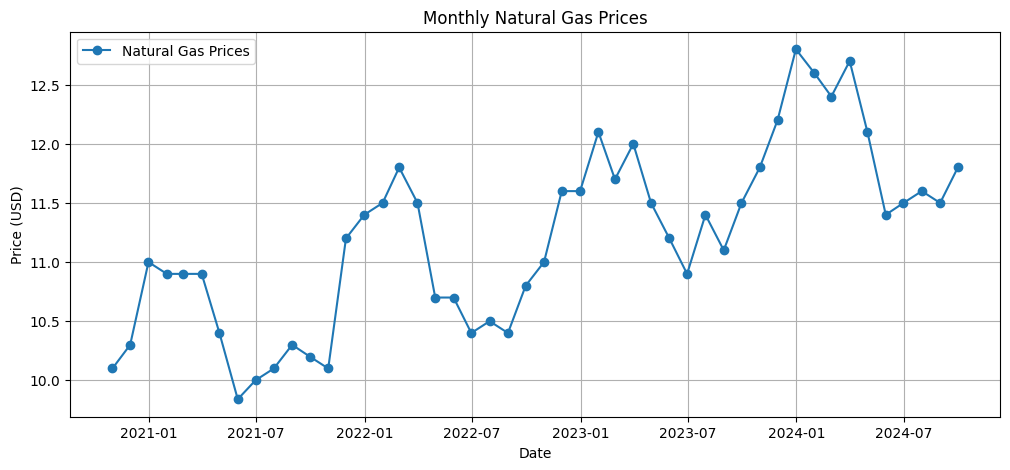

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Prices'], marker='o', label='Natural Gas Prices')
plt.title('Monthly Natural Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()


Analyze Seasonality
To explore if gas prices follow any monthly seasonal pattern:

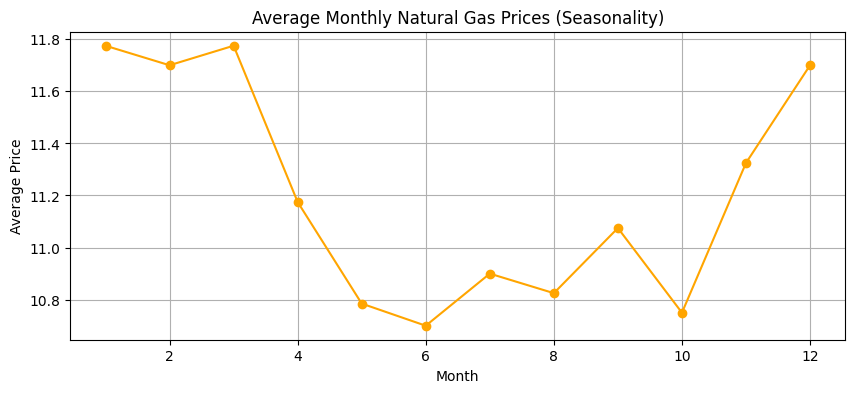

In [ ]:
# Add a Month column
df['Month'] = df.index.month

# Calculate average price for each month
monthly_avg = df.groupby('Month')['Prices'].mean()

# Plot the average monthly prices
plt.figure(figsize=(10, 4))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', color='orange')
plt.title('Average Monthly Natural Gas Prices (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()


Build a SARIMA Forecasting Model
This model accounts for seasonality and trends, great for monthly time series.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df['Prices'], order=(1, 1, 1), seasonal_order=(1, 1, 0, 12), enforce_stationarity=False)
results = model.fit(disp=False)


Forecast for 12 Months
This provides gas price projections for the next 12 months.

In [ ]:
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)

# Create a new date range for forecast
forecast_index = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame({'Prices': forecast.predicted_mean}, index=forecast_index)


/tmp/ipython-input-13-3044011300.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='M')


Combine Historical and Forecasted Data
So we can interpolate values from the full dataset:

In [ ]:
full_df = pd.concat([df[['Prices']], forecast_df])


 Estimate Price for Any Date
 You define a function to return price for any date between Oct 2020 and Sep 2025.

In [ ]:
def estimate_price(date_str):
    try:
        input_date = pd.to_datetime(date_str)
    except ValueError:
        return "Invalid date format. Use YYYY-MM-DD."

    if input_date < full_df.index[0] or input_date > full_df.index[-1]:
        return f"Date {input_date.date()} is out of supported range: {full_df.index[0].date()} to {full_df.index[-1].date()}."

    interpolated = full_df['Prices'].reindex(full_df.index.union([input_date])).sort_index().interpolate(method='time')
    price = interpolated.loc[input_date]
    return f"Estimated natural gas price on {input_date.date()}: ${price:.2f}"


Try calling the function like:

In [ ]:
print(estimate_price("2022-06-15"))  # Within past range
print(estimate_price("2025-08-01"))  # Forecasted future


Estimated natural gas price on 2022-06-15: $10.55
Estimated natural gas price on 2025-08-01: $12.19


Final Visualization (Historical + Forecast)

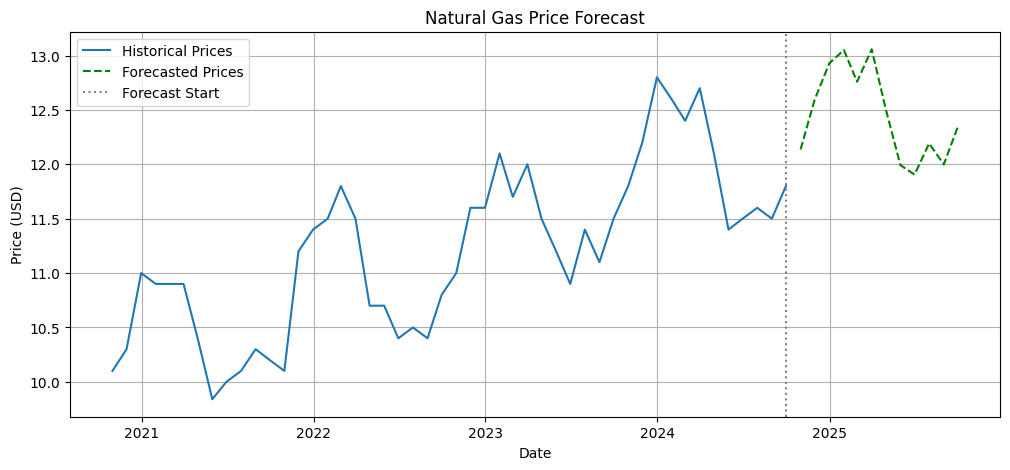

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Prices'], label='Historical Prices')
plt.plot(forecast_df.index, forecast_df['Prices'], linestyle='--', color='green', label='Forecasted Prices')
plt.axvline(df.index[-1], color='gray', linestyle=':', label='Forecast Start')
plt.title("Natural Gas Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()
